In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(celldex)
    library(ShinyCell)
    library(dplyr)
    library(SingleR)
    library(dplyr)
    
})

In [ ]:
counts <- readRDS("data/2023-04-05_rawCounts_Sc_QCed.rds")
metadata <- readRDS("data/2023-04-05_metaData_Sc_QCed.rds")

obj <- CreateSeuratObject(counts = counts, meta.data = metadata, min.cells = 3, min.features = 300)
obj
save(obj, file = "objects/00.rda")

In [ ]:
# QC
obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
obj
save(obj, file = file.path("objects", "01.rda"))

In [ ]:
# Normalization
obj <- SCTransform(obj, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi', conserve.memory = FALSE)
save(obj, file=file.path("objects", "02.rda"))

In [ ]:
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)
save(obj, file=file.path("objects", "03.rda"))

In [ ]:
# Load annotation
monaco.ref <- celldex::MonacoImmuneData()
blueprint.ref <- celldex::BlueprintEncodeData()

In [6]:
# Blueprint annnotation
sce <- LayerData(obj)
blueprint.main <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.main)
obj@meta.data$blueprint.main <- blueprint.main$pruned.labels
save(obj, file=file.path("objects", "04.rda"))

In [7]:
# Monaco annontation
sce <- LayerData(obj)
monaco.fine <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.fine)
obj@meta.data$monaco.fine <- monaco.fine$pruned.labels
save(obj, file=file.path('objects', '05.rda'))

In [8]:
# Update metadata
obj@meta.data$Stim <- obj@meta.data$Type
obj@meta.data$Tissue_Type <- obj@meta.data$broad.group
obj@meta.data$Fine_Cell_Type <- obj@meta.data$fine.type
obj@meta.data$Broad_Cell_Type <- obj@meta.data$broad.type
obj@meta.data$Donor <- gsub("AMPSLEkid_cells", "Donor",  obj@meta.data$sample)
save(obj, file=file.path('objects', '06.rda'))

## Process Individual Cell Types

In [1]:
# load(file=file.path("objects", "02.rda"))

In [ ]:
source("R/process.R")

In [8]:
seu =  get(load(file = "orig_objects/TCellmonaco05.rda"))
seu

An object of class Seurat 
65453 features across 30214 samples within 2 assays 
Active assay: SCT (32333 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [3]:
seu

An object of class Seurat 
65453 features across 8049 samples within 2 assays 
Active assay: SCT (32333 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [8]:
unique(seu@meta.data$Broad_Cell_Type)

[1] "Plasma Cell" "B Cell"

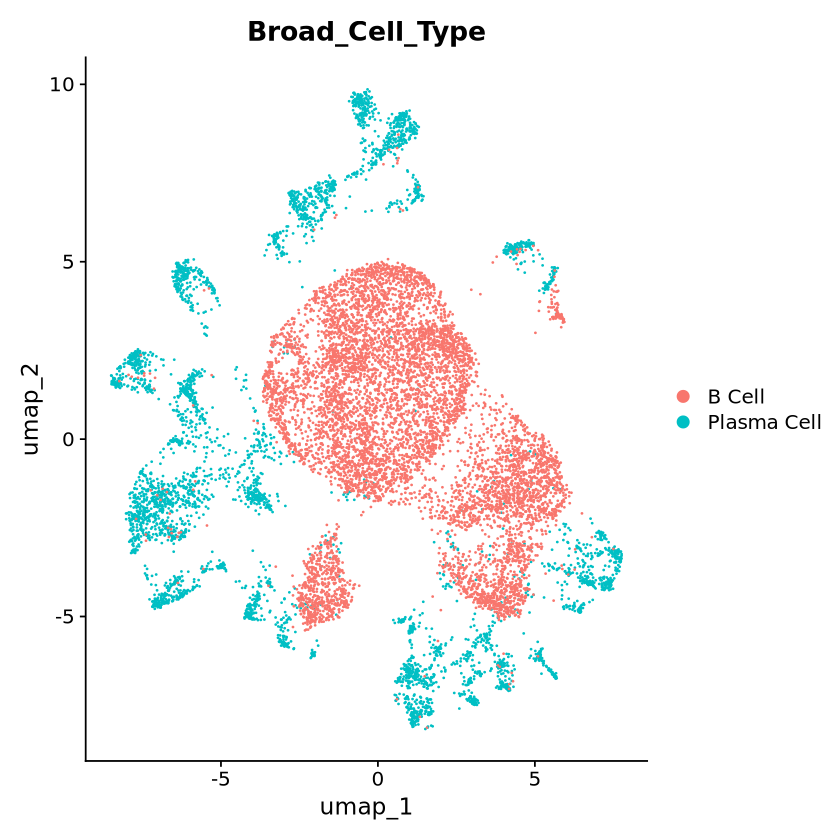

In [17]:
DimPlot(seu, group.by = "Broad_Cell_Type")

In [16]:
seu <- bcells
seu <- SCTransform(seu, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi', conserve.memory = FALSE)
    seu <- RunPCA(seu,npcs = 30, verbose = TRUE)
   seu <-  RunUMAP(seu,reduction = "pca", dims = 1:20)
  seu <-   FindNeighbors(seu,reduction = "pca", dims = 1:20)
  seu <-   FindClusters(seu,resolution = 0.5)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.1



vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 18937 by 4595

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells

Found 147 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18937 genes

Computing corrected count matrix for 18937 genes

Calculating gene attributes

Wall clock passed: Time difference of 17.39676 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 2) for 1 dataset

Getting residuals for block 2(of 2) for 1 dataset

Centering data matrix

Finished calculating residuals for 1

Running SCTransform on layer: counts.2

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 18984 by 8049

Model formula is y ~ log_umi

Get Negative Bi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12644
Number of edges: 422205

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9075
Number of communities: 22
Elapsed time: 1 seconds


In [14]:
### Write shiny files

#bcell and plasma
plasma =  get(load(file = "orig_objects/PlasmaCellmonaco05.rda"))
colnames(plasma@meta.data)[10] <- "monaco.fine"

bcell =  get(load(file = "orig_objects/BCellmonaco05.rda"))
colnames(bcell@meta.data)[10] <- "monaco.fine"

bcells <- merge(x = plasma, y = bcell)

# Recluster
seu <- bcells
seu <- SCTransform(seu, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi', conserve.memory = FALSE)%>%
    RunPCA(npcs = 30, verbose = TRUE)%>%
    RunUMAP(reduction = "pca", dims = 1:20)%>%
    FindNeighbors(reduction = "pca", dims = 1:20)%>%
    FindClusters(resolution = 0.5)

scConf1 = createConfig(seu)
makeShinyFiles(seu, scConf1,gene.mapping = TRUE,shiny.prefix = "sc1",shiny.dir = "amp2_sle_scRNAseq_immune/",gex.assay = "SCT")

#myeloid
seu =  get(load(file = "orig_objects/MyeloidCellmonaco05.rda"))
colnames(seu@meta.data)[10] <- "monaco.fine"
scConf2 = createConfig(seu)
makeShinyFiles(seu, scConf2, gene.mapping = TRUE, shiny.prefix = "sc2", shiny.dir = "amp2_sle_scRNAseq_immune/", gex.assay = "SCT")

#nk
seu =  get(load(file = "orig_objects/NKCellmonaco05.rda"))
colnames(seu@meta.data)[10] <- "monaco.fine"
scConf3 = createConfig(seu)
makeShinyFiles(seu, scConf3, gene.mapping = TRUE, shiny.prefix = "sc3", shiny.dir = "amp2_sle_scRNAseq_immune/", gex.assay = "SCT")


#tcell
seu =  get(load(file = "orig_objects/TCellmonaco05.rda"))
colnames(seu@meta.data)[10] <- "monaco.fine"
scConf4 = createConfig(seu)
makeShinyFiles(seu, scConf4, gene.mapping = TRUE, shiny.prefix = "sc4", shiny.dir = "amp2_sle_scRNAseq_immune/", gex.assay = "SCT")

# All
seu =  get(load(file = "orig_objects/06.rda"))
seu <- SetIdent(seu, value = "Broad_Cell_Type")
cells <-  c('T Cell', 'NK Cell', 'Plasma Cell', 'B Cell', 'Myeloid Cell')
seu <- subset(seu, Broad_Cell_Type  %in%  cells)

# Rename
seu@meta.data$Stim <- seu@meta.data$Type
seu@meta.data$Tissue_Type <- seu@meta.data$broad.group
seu@meta.data$Fine_Cell_Type <- seu@meta.data$fine.type
seu@meta.data$Broad_Cell_Type <- seu@meta.data$broad.type
seu@meta.data$Donor <- gsub("AMPSLEkid_cells", "Donor",  seu@meta.data$sample)

columns_to_keep <-  c('orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Donor', 'Stim', 'Tissue_Type', 'Fine_Cell_Type', 'Broad_Cell_Type', 'monaco.fine')
seu@meta.data <- seu@meta.data[, columns_to_keep, drop = FALSE]

# Recluster
seu <- RunPCA(seu, npcs = 30, verbose = TRUE)
seu <- RunUMAP(seu, reduction = "pca", dims = 1:20)
seu <- FindNeighbors(seu, reduction = "pca", dims = 1:20)
seu <- FindClusters(seu, resolution = 0.5)

scConf5 = createConfig(seu, maxLevels = 60)
makeShinyFiles(seu, scConf5, gene.mapping = TRUE, shiny.prefix = "sc5", shiny.dir = "amp2_sle_scRNAseq_immune/", gex.assay = "SCT")

makeShinyCodesMulti( shiny.title = "AMP Phase II SLE, Immune Cells", shiny.footnotes = NULL, shiny.prefix = c("sc1", "sc2", "sc3", "sc4", "sc5"), shiny.headers = c("B and Plasma Cell", "Myeloid", "NK", "T Cell", "All Cells"),  shiny.dir = "amp2_sle_scRNAseq_immune/") 

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.1

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 18937 by 4595

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells

Found 147 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18937 genes

Computing corrected count matrix for 18937 genes

Calculating gene attributes

Wall clock passed: Time difference of 21.40592 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 2) for 1 dataset

Getting residuals for block 2(of 2) for 1 dataset

Centering data matrix

Finished calculating residuals for 1

Running SCTransform on layer: counts.2

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12644
Number of edges: 422205

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9075
Number of communities: 22
Elapsed time: 1 seconds


ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
Stim,Stim,Control|LN,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue_Type,Tissue_Type,Immune,black,1,FALSE,FALSE
Fine_Cell_Type,Fine_Cell_Type,0. MME+ BCL6+ B|1. MHC2+ IGHM- B|10. JCHAIN+ IGA+ IGL+ Plasma|11. IGHG+ IGL+ Plasma|2. IGHD+ FCER2+ CD22+ B|3. CD24+ CD80+ IGHM+ B|4. BCL11A+ TCF4+ IGHE+ B|5. ITGAX+ TBX21+ B|6. CD38++ CD27++ IGHD- Plasma|7. IGHG+ IGL- Plasma|8. JCHAIN+ IGA+ IGL- Plasma|9. IGHG+ IGL- Plasma,#A6CEE3|#1F78B4|#B2DF8A|#33A02C|#FB9A99|#E31A1C|#FDBF6F|#FF7F00|#CAB2D6|#6A3D9A|#FFFF99|#B15928,3,TRUE,FALSE
Broad_Cell_Type,Broad_Cell_Type,B Cell|Plasma Cell,#A6CEE3|#B15928,1,TRUE,FALSE
SCT_snn_res.0.5,SCT_snn_res.0.5,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21,#A6CEE3|#5FA0CA|#257CB2|#72B29C|#A5D981|#63B84F|#4F9F3B|#B89B74|#F68181|#E93E3F|#E9412F|#F6975B|#FDAC4F|#FE8B15|#ED8F47|#D1AAB7|#A585BF|#73489F|#A99099|#F7F599|#D9AF63|#B15928,6,TRUE,FALSE
seurat_clusters,seurat_clusters,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21,#A6CEE3|#5FA0CA|#257CB2|#72B29C|#A5D981|#63B84F|#4F9F3B|#B89B74|#F68181|#E93E3F|#E9412F|#F6975B|#FDAC4F|#FE8B15|#ED8F47|#D1AAB7|#A585BF|#73489F|#A99099|#F7F599|#D9AF63|#B15928,6,TRUE,FALSE


ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
Stim,Stim,Control|LN,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue_Type,Tissue_Type,Immune,black,1,FALSE,FALSE
Fine_Cell_Type,Fine_Cell_Type,0. CD16+ CX3CR1+ Mono|1. CD14+ CD16+ Mono|10. SELENOP+ LYVE1lo Mac|11. C1Qhi GPNMBhi Mac|12. SELENOP+ LYVE1hi Mac|13. CCR7+ LAMP3+ cDC2|14. APOC1hi C3hi Mac|15. MHC2lo cDC2|16. APOC1lo C3hi Mac|17. MHC2hi cDC2|18. CENPF+ MKI67+ Proliferating|19. cDC1|2. CD14+ CCR2+ Mono|20. pDC|3. CD14+ CCL2+ Mono|4. Mast Cell|5. C1Qlo NUPR1hi Mac|6. SELENOP+ TIMP1+ Mac|7. C1Qlo FABP5hi SPP1hi Mac|8. SELENOP- TIMP1+ Mac|9. C1Qhi FABP5hi SPP1hi Mac,#A6CEE3|#5B9EC9|#2D82AF|#7EBA98|#98D277|#52AF43|#6F9E4C|#DD9A88|#F16667|#E42022|#F06C45|#FDBB69|#FE982C|#F78620|#D9A295|#B294C7|#7D54A5|#9E8099|#F0EB99|#DBB466|#B15928,6,TRUE,FALSE
Broad_Cell_Type,Broad_Cell_Type,Myeloid Cell,black,1,FALSE,FALSE
SCT_snn_res.0.5,SCT_snn_res.0.5,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14,#A6CEE3|#3B8ABE|#72B29C|#84C868|#4F9F3B|#EC9A91|#E93E3F|#F06C45|#FDAC4F|#FB820F|#D1AAB7|#8C66AF|#A99099|#EEDB80|#B15928,4,TRUE,FALSE
seurat_clusters,seurat_clusters,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14,#A6CEE3|#3B8ABE|#72B29C|#84C868|#4F9F3B|#EC9A91|#E93E3F|#F06C45|#FDAC4F|#FB820F|#D1AAB7|#8C66AF|#A99099|#EEDB80|#B15928,4,TRUE,FALSE


ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
Stim,Stim,Control|LN,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue_Type,Tissue_Type,Immune,black,1,FALSE,FALSE
Fine_Cell_Type,Fine_Cell_Type,0.CD56lo NK|3. CD56bright NK,#A6CEE3|#B15928,1,TRUE,FALSE
Broad_Cell_Type,Broad_Cell_Type,NK Cell,black,1,FALSE,FALSE
SCT_snn_res.0.5,SCT_snn_res.0.5,0|1|2|3|4|5|6,#A6CEE3|#99CD91|#B89B74|#F06C45|#ED8F47|#825D99|#B15928,2,TRUE,FALSE
seurat_clusters,seurat_clusters,0|1|2|3|4|5|6,#A6CEE3|#99CD91|#B89B74|#F06C45|#ED8F47|#825D99|#B15928,2,TRUE,FALSE


ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
Stim,Stim,Control|LN,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue_Type,Tissue_Type,Immune,black,1,FALSE,FALSE
Fine_Cell_Type,Fine_Cell_Type,1. CTL|10. GZMK+ CD8+ ITGAE+|11. CD4+ CD28+ CCR7- SELL-|12. CD4?|13. GZMK+ CD8+ CD69+|14. CD4+ CD69+ ITGAE+ S1P1- JUNhi|15. CD4+ CD69+ ITGAE+ S1P1- JUNlo|16. CD4+ CD28+ SELL+ CCR7+|17. ILCs|18. CD4+ RORC+ KLRB1+ CCR6+|19. CD4+ CCR7+ CD28+ SELL+ Ribohi|2. SYNEhi CTL|20. CD4+ IL2RA++ FOXP3++|21. CD4+ SELL+ CD28+ CCR7+ IL2RA+ FOXP3+|22. CD4+ PDCD1+ CXCR5+|4. Proliferating|5. GZMK+ CD8+ NKG7lo|6. GZMK+ CD8 NKG7hi|7. GZMK+ CD8+ CD28+ CCR7- SELL-|8. GZMK+ CD8+ NEAT1+|9. GZMK+ CD8+ CD69+ ITGAE+ S1P1-,#A6CEE3|#5B9EC9|#2D82AF|#7EBA98|#98D277|#52AF43|#6F9E4C|#DD9A88|#F16667|#E42022|#F06C45|#FDBB69|#FE982C|#F78620|#D9A295|#B294C7|#7D54A5|#9E8099|#F0EB99|#DBB466|#B15928,6,TRUE,FALSE
Broad_Cell_Type,Broad_Cell_Type,T Cell,black,1,FALSE,FALSE
SCT_snn_res.0.5,SCT_snn_res.0.5,0|1|2|3|4|5|6|7|8|9|10|11,#A6CEE3|#1F78B4|#B2DF8A|#33A02C|#FB9A99|#E31A1C|#FDBF6F|#FF7F00|#CAB2D6|#6A3D9A|#FFFF99|#B15928,3,TRUE,FALSE
seurat_clusters,seurat_clusters,0|1|2|3|4|5|6|7|8|9|10|11,#A6CEE3|#1F78B4|#B2DF8A|#33A02C|#FB9A99|#E31A1C|#FDBF6F|#FF7F00|#CAB2D6|#6A3D9A|#FFFF99|#B15928,3,TRUE,FALSE


PC_ 1 
Positive:  LYZ, TYROBP, C1QA, C1QB, FCER1G, AIF1, S100A9, C1QC, HLA-DRA, CTSS 
	   LST1, FCN1, HLA-DPA1, S100A8, HLA-DPB1, MS4A7, S100A4, CD14, FABP5, HLA-DRB1 
	   FCGR3A, TMSB4X, APOC1, SRGN, IFI30, MS4A6A, CD163, ITGB2, HLA-DQA1, CD74 
Negative:  UMOD, ALDOB, MT1G, DEFB1, GPX3, SLC12A1, FXYD2, WFDC2, AQP2, CALB1 
	   IGFBP5, MT1H, MIOX, SLC12A3, FXYD4, KNG1, TMEM52B, IGFBP7, GATM, ATP1B1 
	   MMP7, CRYAB, S100A2, GSTA1, MGP, ADIRF, PDZK1IP1, CLU, SLPI, TIMP3 
PC_ 2 
Positive:  C1QA, C1QB, C1QC, UMOD, LYZ, APOC1, APOE, ALDOB, FTL, MT1G 
	   DEFB1, HLA-DRA, CD14, TYROBP, CD163, RNASE1, GPX3, SPP1, SLC12A1, FXYD2 
	   AIF1, WFDC2, FABP5, HLA-DPA1, VSIG4, HLA-DRB1, MS4A6A, AQP2, CD68, MS4A7 
Negative:  NKG7, GNLY, CCL5, GZMA, GZMB, CCL4, PRF1, CD52, CST7, GZMH 
	   HCST, CTSW, CD3D, TMSB4X, CD2, IGKC, KLRD1, CORO1A, KLRB1, TRBC2 
	   TRBC1, PTPRC, LTB, CD7, FGFBP2, CD3G, TRAC, CD247, RAC2, S100A4 
PC_ 3 
Positive:  IGKC, IGHG1, IGHG3, MZB1, IGHG4, JCHAIN, IGLC2, IGLC3, IGHM, IGHG

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 72859
Number of edges: 2357412

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9303
Number of communities: 20
Elapsed time: 15 seconds


ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
Stim,Stim,Control|LN,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue_Type,Tissue_Type,Immune,black,1,FALSE,FALSE
Fine_Cell_Type,Fine_Cell_Type,0. CD16+ CX3CR1+ Mono|0. MME+ BCL6+ B|0.CD56lo NK|1. CD14+ CD16+ Mono|1. CTL|1. MHC2+ IGHM- B|10. GZMK+ CD8+ ITGAE+|10. JCHAIN+ IGA+ IGL+ Plasma|10. SELENOP+ LYVE1lo Mac|11. C1Qhi GPNMBhi Mac|11. CD4+ CD28+ CCR7- SELL-|11. IGHG+ IGL+ Plasma|12. CD4?|12. SELENOP+ LYVE1hi Mac|13. CCR7+ LAMP3+ cDC2|13. GZMK+ CD8+ CD69+|14. APOC1hi C3hi Mac|14. CD4+ CD69+ ITGAE+ S1P1- JUNhi|15. CD4+ CD69+ ITGAE+ S1P1- JUNlo|15. MHC2lo cDC2|16. APOC1lo C3hi Mac|16. CD4+ CD28+ SELL+ CCR7+|17. ILCs|17. MHC2hi cDC2|18. CD4+ RORC+ KLRB1+ CCR6+|18. CENPF+ MKI67+ Proliferating|19. CD4+ CCR7+ CD28+ SELL+ Ribohi|19. cDC1|2. CD14+ CCR2+ Mono|2. IGHD+ FCER2+ CD22+ B|2. SYNEhi CTL|20. CD4+ IL2RA++ FOXP3++|20. pDC|21. CD4+ SELL+ CD28+ CCR7+ IL2RA+ FOXP3+|22. CD4+ PDCD1+ CXCR5+|3. CD14+ CCL2+ Mono|3. CD24+ CD80+ IGHM+ B|3. CD56bright NK|4. BCL11A+ TCF4+ IGHE+ B|4. Mast Cell|4. Proliferating|5. C1Qlo NUPR1hi Mac|5. GZMK+ CD8+ NKG7lo|5. ITGAX+ TBX21+ B|6. CD38++ CD27++ IGHD- Plasma|6. GZMK+ CD8 NKG7hi|6. SELENOP+ TIMP1+ Mac|7. C1Qlo FABP5hi SPP1hi Mac|7. GZMK+ CD8+ CD28+ CCR7- SELL-|7. IGHG+ IGL- Plasma|8. GZMK+ CD8+ NEAT1+|8. JCHAIN+ IGA+ IGL- Plasma|8. SELENOP- TIMP1+ Mac|9. C1Qhi FABP5hi SPP1hi Mac|9. GZMK+ CD8+ CD69+ ITGAE+ S1P1-|9. IGHG+ IGL- Plasma,#A6CEE3|#8BBCD9|#70ABD0|#559AC6|#3A89BD|#1F78B4|#3C8CAB|#59A1A3|#77B59A|#94CA92|#B2DF8A|#98D277|#7FC564|#65B951|#4CAC3E|#33A02C|#5B9E41|#839D57|#AA9C6D|#D39B83|#FB9A99|#F68080|#F16667|#EC4D4E|#E73335|#E31A1C|#E83A2C|#ED5B3D|#F27C4D|#F79D5E|#FDBF6F|#FDB258|#FDA542|#FE982C|#FE8B16|#FF7F00|#F4892A|#E99355|#DF9D80|#D4A7AB|#CAB2D6|#B69ACA|#A383BE|#906BB2|#7D54A6|#6A3D9A|#876399|#A58A99|#C3B199|#E1D899|#FEFE99|#EFDD82|#DFBC6B|#D09B55|#C07A3E|#B15928,14,TRUE,FALSE
Broad_Cell_Type,Broad_Cell_Type,B Cell|Myeloid Cell|NK Cell|Plasma Cell|T Cell,#A6CEE3|#52AF43|#F06C45|#B294C7|#B15928,2,TRUE,FALSE
monaco.fine,monaco.fine,Central memory CD8 T cells|Classical monocytes|Effector memory CD8 T cells|Exhausted B cells|Follicular helper T cells|Intermediate monocytes|Low-density basophils|Low-density neutrophils|MAIT cells|Myeloid dendritic cells|Naive B cells|Naive CD4 T cells|Naive CD8 T cells|Natural killer cells|Non classical monocytes|Non-switched memory B cells|Non-Vd2 gd T cells|Plasmablasts|Plasmacytoid dendritic cells|Progenitor cells|Switched memory B cells|T regulatory cells|Terminal effector CD4 T cells|Terminal effector CD8 T cells|Th1 cells|Th1/Th17 cells|Th17 cells|Th2 cells|Vd2 gd T cells,#A6CEE3|#70ACD0|#3B8ABE|#398AAC|#72B29C|#ACDB8B|#84C868|#52AF43|#4F9F3B|#9E9C66|#EC9A91|#F37070|#E93E3F|#E52B24|#F06C45|#FAAD66|#FDAC4F|#FE9323|#FB820F|#E69663|#D1AAB7|#B294C7|#8C66AF|#6F4399|#A99099|#E4DC99|#EEDB80|#CF9A54|#B15928,8,TRUE,FALSE
SCT_snn_res.0.5,SCT_snn_res.0.5,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19,#A6CEE3|#579CC7|#3688AD|#8BC395|#89CB6C|#40A635|#919D5F|#F99392|#EB494A|#E83C2D|#F79C5D|#FDA746|#FE8205|#E39970|#BFA5CF|#8861AC|#917099|#E7E099|#DEB969|#B15928,5,TRUE,FALSE


In [18]:
system("R -e \"shiny::runApp('amp2_sle_scRNAseq_immune')\"")

In [ ]:
### Write shiny files

#dn
seu =  get(load(file = "objects/DNblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf1 = createConfig(seu)
makeShinyFiles(seu, scConf1,
             gene.mapping = TRUE,
             shiny.prefix = "sc1",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

#glom
seu =  get(load(file = "objects/GLOMblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf2 = createConfig(seu)
makeShinyFiles(seu, scConf2,
             gene.mapping = TRUE,
             shiny.prefix = "sc2",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

#intl
seu =  get(load(file = "objects/INTLblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf3 = createConfig(seu)
makeShinyFiles(seu, scConf3,
             gene.mapping = TRUE,
             shiny.prefix = "sc3",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

#loh
seu =  get(load(file = "objects/LOHblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf4 = createConfig(seu)
makeShinyFiles(seu, scConf4,
             gene.mapping = TRUE,
             shiny.prefix = "sc4",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

#und   
seu =  get(load(file = "objects/UNDblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf5 = createConfig(seu)
makeShinyFiles(seu, scConf5,
             gene.mapping = TRUE,
             shiny.prefix = "sc11",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

#pt
seu =  get(load(file = "objects/PTblueprint05.rda"))
colnames(seu@meta.data)[10] <- "blueprint.main"
scConf6 = createConfig(seu)
makeShinyFiles(seu, scConf6,
             gene.mapping = TRUE,
             shiny.prefix = "sc6",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

# All
seu =  get(load(file = "objects/06.rda"))
seu <- SetIdent(seu, value = "Broad_Cell_Type")
cells <-  c('PT', 'INTL', 'GLOM', 'DN', 'LOH', 'UND')
seu <- subset(seu, Broad_Cell_Type  %in%  cells)

# Rename
seu@meta.data$Stim <- seu@meta.data$Type
seu@meta.data$Tissue_Type <- seu@meta.data$broad.group
seu@meta.data$Fine_Cell_Type <- seu@meta.data$fine.type
seu@meta.data$Broad_Cell_Type <- seu@meta.data$broad.type
seu@meta.data$Donor <- gsub("AMPSLEkid_cells", "Donor",  obj@meta.data$sample)

columns_to_keep <-  c('orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Donor', 'Stim', 'Tissue_Type',
 'Fine_Cell_Type', 'Broad_Cell_Type', 'blueprint.main')
seu@meta.data <- seu@meta.data[, columns_to_keep, drop = FALSE]

# Recluster
seu <- RunPCA(seu, npcs = 30, verbose = TRUE)
seu <- RunUMAP(seu, reduction = "pca", dims = 1:20)
seu <- FindNeighbors(seu, reduction = "pca", dims = 1:20)
seu <- FindClusters(seu, resolution = 0.5)

scConf7 = createConfig(seu)
makeShinyFiles(seu, scConf7,
             gene.mapping = TRUE,
             shiny.prefix = "sc7",
             shiny.dir = "amp2_sle_scRNAseq_kidney/",
             gex.assay = "SCT")

makeShinyCodesMulti(
  shiny.title = "AMP Phase II SLE, Structural Cells", shiny.footnotes = NULL,
  shiny.prefix = c("sc1", "sc2", "sc3", "sc4", "sc5", "sc6", "sc7"),
  shiny.headers = c("Distal Nephron (DN)", "Glomerulus (GLOM)", "Interstitial (INTL)", "Loop of Henle (LOH)",
   "Undetermined (UND)", "Proximal Tube (PT)", "All Cells"), 
  shiny.dir = "amp2_sle_scRNAseq_kidney/") 

In [4]:
# system("R -e \"shiny::runApp('amp2_sle_scRNAseq_kidney')\"")